In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 15.7 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.75
batch_size_value = 64
n_repeats = 3
n_epochs = 50
lr = 1e-3
noise = 'topological'
# noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'gaussian':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:02<00:00, 4732.16it/s]



topological noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 4841.74it/s]


topological noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

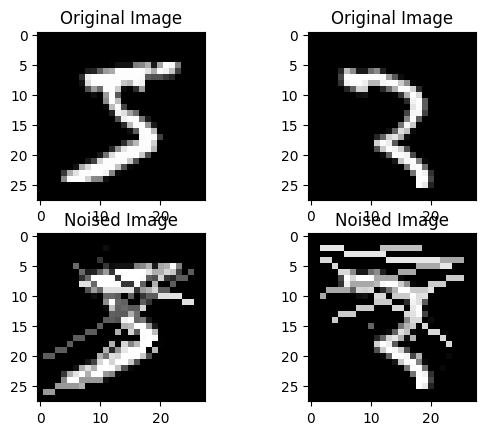

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

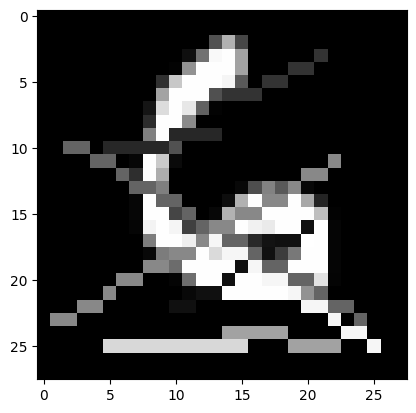

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

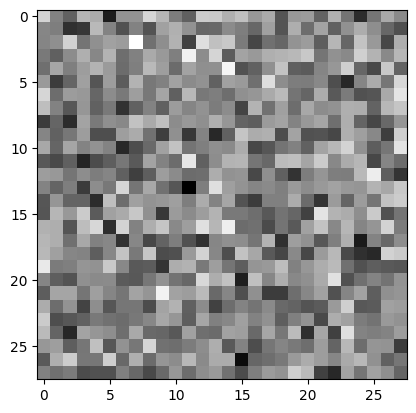

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(311.0061, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2166.493408203125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


  0 5046.0527 1867.5164


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  1 4074.8018 1752.1174


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


  2 3702.6970 1645.7590


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


  3 3517.7117 1583.8898


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


  4 3411.1665 1565.8763


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


  5 3333.7666 1566.2346


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  6 3269.3049 1545.5651


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  7 3220.0479 1530.6721


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


  8 3175.2900 1528.4232


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  9 3144.0620 1529.8087


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 10 3111.0171 1524.9580


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 11 3080.2495 1526.9248


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 12 3057.4287 1526.1859


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 13 3039.7524 1522.6528


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 14 3016.1433 1524.8230


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 15 2989.8442 1524.0165


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 16 2967.4363 1524.7406


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 17 2938.2986 1526.6453


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 18 2916.0430 1524.9631


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 19 2898.4199 1521.1156


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 20 2884.5132 1519.7109


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 21 2871.9768 1519.8492


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 22 2857.3259 1518.9246


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 23 2853.6946 1517.0698


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 24 2843.4150 1514.9766


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 25 2837.9514 1516.0073


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 26 2831.6218 1513.1506


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 27 2826.7019 1513.3645


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 28 2821.8508 1510.9041


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 29 2818.0295 1508.5522


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 30 2815.6143 1505.3207


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 31 2808.4170 1504.8760


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 32 2801.1106 1504.2444


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 33 2791.6245 1503.6899


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 34 2779.0979 1505.0732


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 35 2769.1201 1506.6855


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 36 2760.3867 1504.2032


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 37 2752.3618 1503.7765


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 38 2746.6843 1504.5187


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 39 2741.5872 1502.1158


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 40 2731.2893 1505.9359


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 41 2726.7805 1504.0244


100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


 42 2720.9419 1503.4526


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 43 2717.7139 1503.0973


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 44 2714.4980 1501.8317


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 45 2712.0601 1500.4998


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 46 2710.5967 1500.7657


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 47 2707.6384 1497.2371


100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


 48 2705.1970 1499.3634


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 49 2699.4236 1497.4011

  2 MSE    Topo  


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


  0 5094.7612 1763.8770


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


  1 4138.2559 1611.4388


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


  2 3736.9583 1544.7498


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


  3 3415.0566 1552.8801


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  4 3217.5754 1543.3621


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  5 3078.5625 1542.4089


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  6 2993.1577 1539.8020


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  7 2918.0327 1539.4028


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


  8 2871.4236 1536.6414


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


  9 2831.0916 1537.6075


100%|██████████| 157/157 [02:55<00:00,  1.11s/it]


 10 2796.5825 1534.4911


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 11 2769.9658 1532.1748


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 12 2741.7380 1530.2605


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 13 2714.3301 1530.1285


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 14 2694.3687 1530.0587


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 15 2675.3374 1525.6635


100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


 16 2653.8850 1524.2128


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 17 2637.4241 1524.9066


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 18 2620.7947 1523.4457


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 19 2608.2644 1521.1202


100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


 20 2597.4250 1521.1479


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 21 2590.1426 1519.5460


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 22 2583.6970 1517.9584


100%|██████████| 157/157 [02:55<00:00,  1.11s/it]


 23 2579.5813 1516.3210


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 24 2572.5652 1514.2633


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 25 2565.5308 1511.4166


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 26 2561.6880 1510.5444


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 27 2557.7886 1509.8248


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 28 2550.4929 1508.1884


100%|██████████| 157/157 [02:59<00:00,  1.14s/it]


 29 2543.6450 1507.7400


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 30 2538.5708 1508.1749


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 31 2535.0554 1506.5428


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 32 2533.3938 1505.7325


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 33 2531.0391 1505.6335


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 34 2526.3359 1503.5552


100%|██████████| 157/157 [02:59<00:00,  1.14s/it]


 35 2526.0696 1497.3612


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


 36 2518.9331 1500.5299


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 37 2519.1409 1499.9751


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 38 2515.0901 1499.7982


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 39 2511.6753 1499.8480


100%|██████████| 157/157 [02:59<00:00,  1.14s/it]


 40 2509.1987 1497.2427


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


 41 2504.0891 1499.7306


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 42 2501.9746 1497.5757


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 43 2499.0601 1497.1519


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 44 2497.1482 1495.7863


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 45 2495.5771 1496.9027


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 46 2493.5325 1498.2859


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 47 2489.8845 1494.4744


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


 48 2488.8057 1495.5638


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 49 2486.7656 1495.5415

  3 MSE    Topo  


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


  0 5137.7651 1692.4835


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  1 4257.3203 1563.1471


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


  2 3783.8638 1540.9750


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  3 3585.7700 1529.8766


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  4 3404.2493 1534.3031


100%|██████████| 157/157 [02:53<00:00,  1.11s/it]


  5 3268.2593 1532.5070


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  6 3191.2078 1524.8311


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


  7 3129.6599 1523.0127


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


  8 3085.5007 1522.3112


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


  9 3044.4724 1522.7306


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 10 3008.6504 1519.7787


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 11 2972.9800 1517.9381


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 12 2943.9050 1518.6775


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 13 2913.6357 1515.9333


100%|██████████| 157/157 [02:54<00:00,  1.11s/it]


 14 2887.6675 1516.1178


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 15 2869.4434 1516.1907


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 16 2857.1245 1511.2643


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 17 2847.7393 1509.6228


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 18 2838.9963 1510.2361


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 19 2827.9192 1509.1206


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 20 2816.9128 1507.2686


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


 21 2805.3376 1510.3428


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 22 2796.2212 1509.7725


100%|██████████| 157/157 [02:58<00:00,  1.13s/it]


 23 2788.4978 1510.1503


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 24 2780.7278 1507.5098


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 25 2769.3604 1509.0634


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 26 2760.6682 1509.2567


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 27 2752.0928 1506.2263


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 28 2745.0308 1505.9103


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 29 2739.5771 1504.9390


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


 30 2732.1870 1504.1039


100%|██████████| 157/157 [03:00<00:00,  1.15s/it]


 31 2730.3528 1503.3207


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


 32 2723.3115 1504.4561


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 33 2715.5415 1505.0466


100%|██████████| 157/157 [02:55<00:00,  1.11s/it]


 34 2708.5024 1504.8409


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 35 2700.1099 1506.4991


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 36 2694.6804 1506.1521


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 37 2690.9443 1506.0767


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 38 2687.2236 1505.4921


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 39 2682.5447 1504.1530


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 40 2675.7588 1506.6348


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 41 2667.7925 1508.1541


100%|██████████| 157/157 [02:58<00:00,  1.13s/it]


 42 2663.5188 1504.9259


100%|██████████| 157/157 [02:58<00:00,  1.14s/it]


 43 2659.2651 1506.5465


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]


 44 2655.8103 1503.1780


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 45 2651.6516 1504.8239


100%|██████████| 157/157 [02:56<00:00,  1.12s/it]


 46 2649.0173 1504.7513


100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


 47 2646.8730 1505.8533


100%|██████████| 157/157 [02:55<00:00,  1.12s/it]


 48 2644.6570 1504.6696


100%|██████████| 157/157 [02:57<00:00,  1.13s/it]

 49 2640.6099 1503.1453

CPU times: user 14h 21min 26s, sys: 54.9 s, total: 14h 22min 20s
Wall time: 7h 18min 34s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

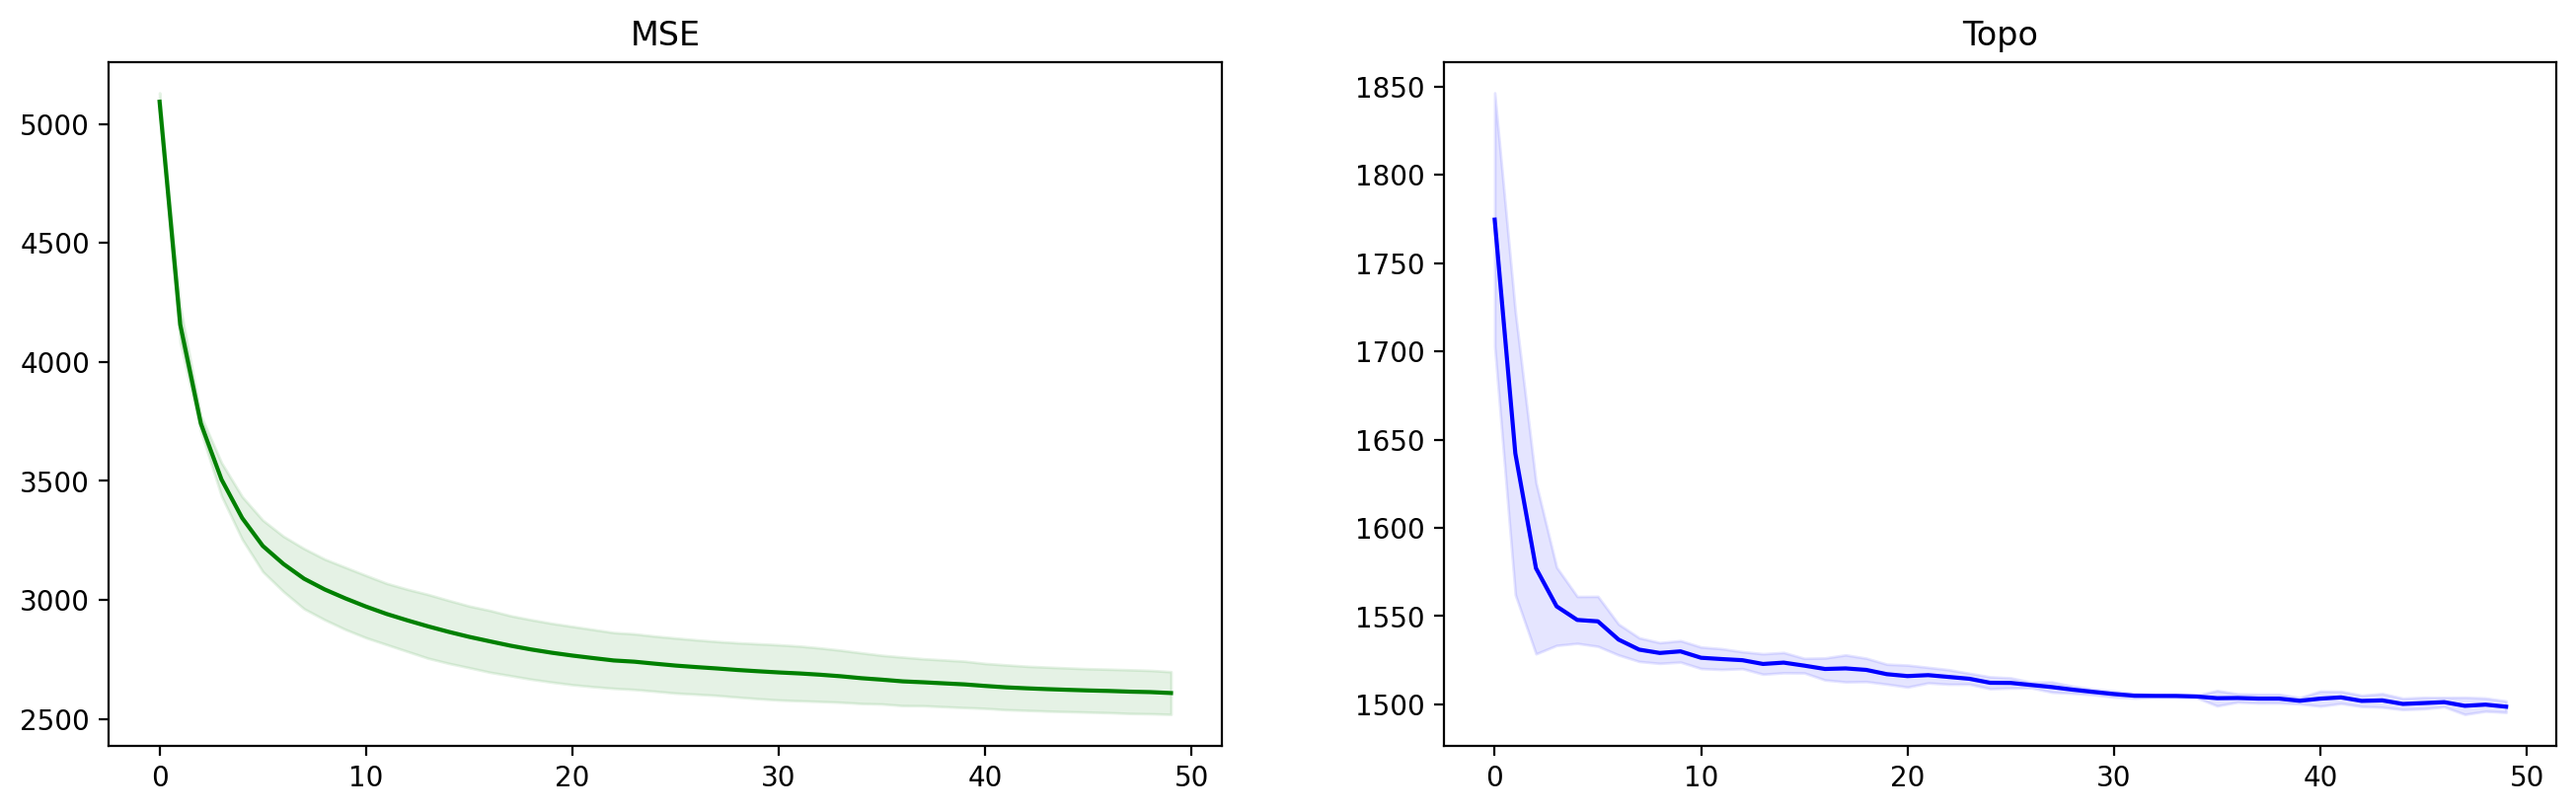

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

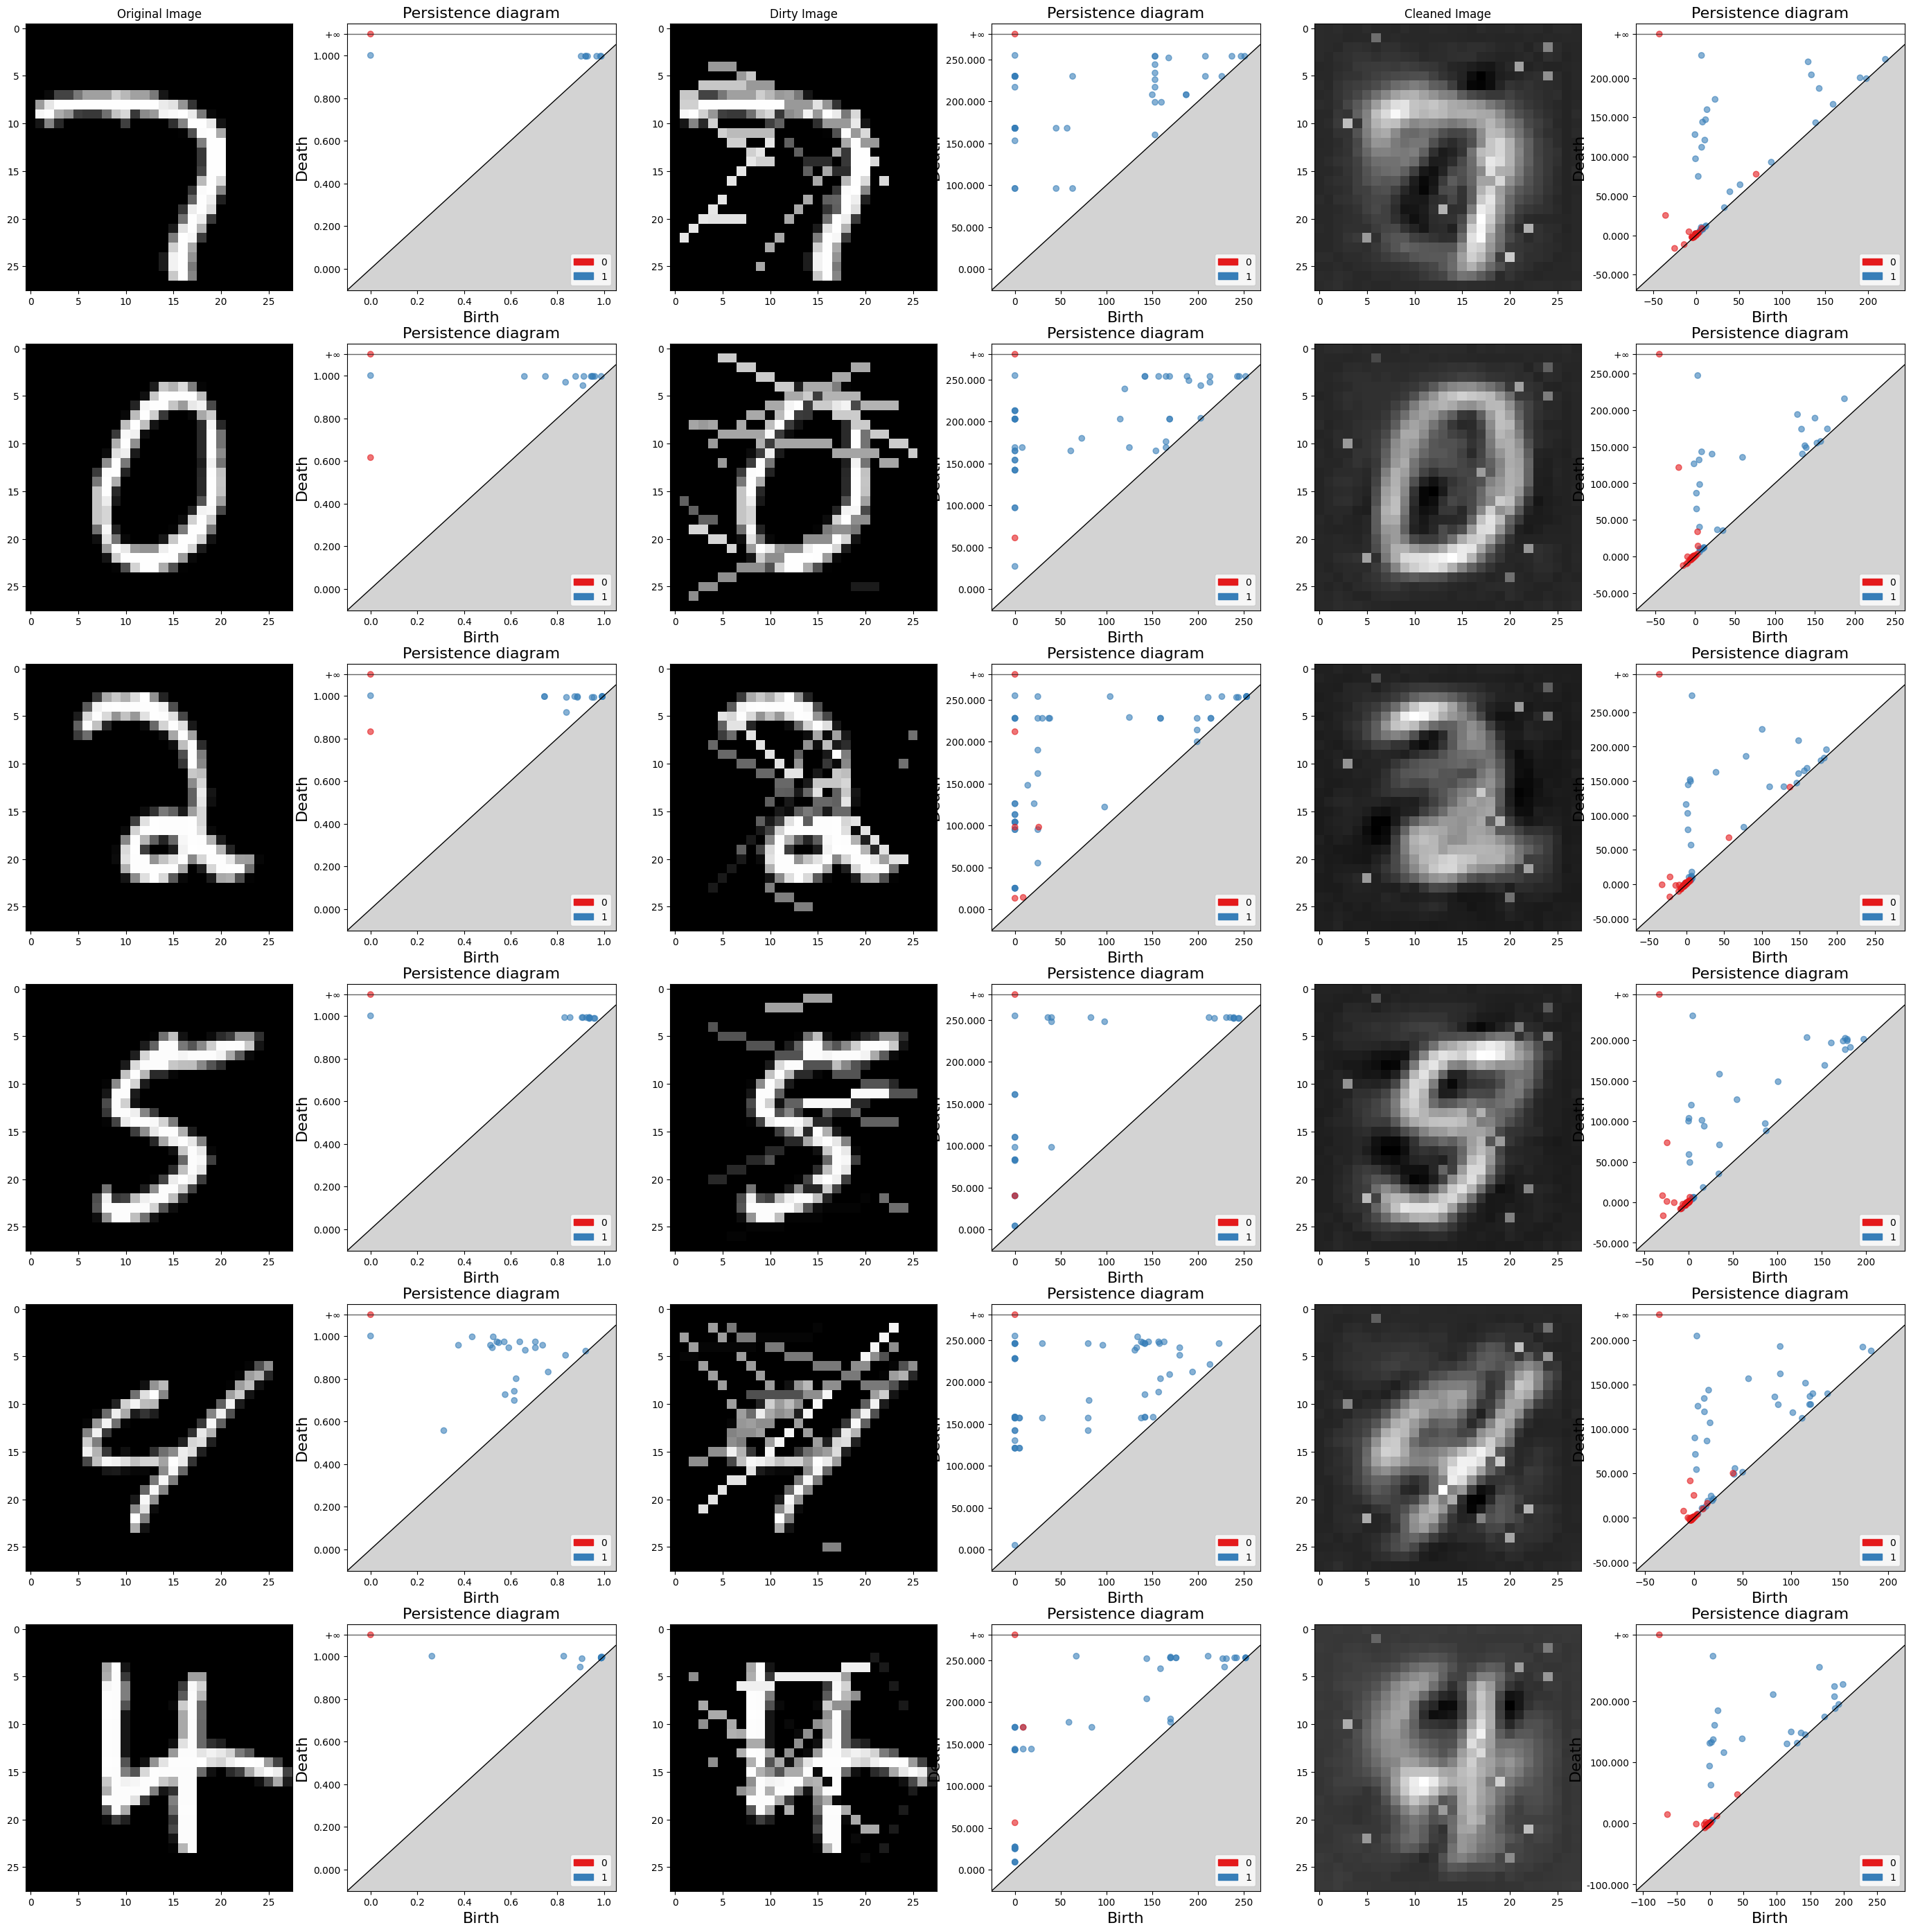

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[5046.05273438 1867.51635742]
  [4074.80175781 1752.11743164]
  [3702.69702148 1645.7590332 ]
  [3517.71166992 1583.88977051]
  [3411.16650391 1565.87634277]
  [3333.76660156 1566.23461914]
  [3269.30493164 1545.56506348]
  [3220.04785156 1530.67211914]
  [3175.29003906 1528.42321777]
  [3144.06201172 1529.80871582]
  [3111.01708984 1524.95800781]
  [3080.24951172 1526.92480469]
  [3057.42871094 1526.18591309]
  [3039.75244141 1522.65283203]
  [3016.14331055 1524.82299805]
  [2989.84423828 1524.01647949]
  [2967.4362793  1524.74060059]
  [2938.29858398 1526.64526367]
  [2916.04296875 1524.96313477]
  [2898.41992188 1521.11560059]
  [2884.51318359 1519.7109375 ]
  [2871.97680664 1519.84924316]
  [2857.32592773 1518.92456055]
  [2853.69458008 1517.06982422]
  [2843.41503906 1514.9765625 ]
  [2837.95141602 1516.00732422]
  [2831.62182617 1513.15063477]
  [2826.7019043  1513.36450195]
  [2821.85083008 1510.90405273]
  [2818.02954102 1508.55224609]
  [2815.61425781 1505.32067871]
  [2808.